In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score,confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
# Load the data
data = pd.read_csv('new_synthetic_data_credit_assigned.csv')

# Separate features and target
X = data.drop(columns=['target'])
y = data['target']

# Define the ColumnTransformer
# Remove the 'sparse=False' argument from OneHotEncoder
transformer = ColumnTransformer(transformers=[
    ('tnf1', OneHotEncoder(drop='first', handle_unknown='ignore'), # Changed here to handle_unknown='ignore'
     ['GENDER', 'MARITAL STATUS', 'ARE YOU THE PRIMARY EARNER OF YOUR FAMILY ?',
      'SKILL 1', 'SKILL 2', 'SKILL 3',
      'DO YOU HAVE ANY CERTIFICATION OF THE ABOVE-MENTIONED SKILL SET?',
      'OWNERSHIP ( includes Land,machine)',
      'Relation with primary earner ?']),
    ('tnf2', OrdinalEncoder(categories=[['Class III','Class IV', 'Class V','Class v', 'ClassV', 'Class VI', 'Class VII', 'Class VIII', 'Class IX','HS', 'HSLC', 'BA Ongoing', 'BCom','B Com', 'BA ','BA', 'BSc', 'MSc', 'MCA', 'PhD']], handle_unknown='use_encoded_value', unknown_value=-1), # Changed here to handle_unknown='use_encoded_value' and  unknown_value=-1
     ['WHAT IS YOUR HIGHEST EDUCATIONAL QUALIFICATION?']),

], remainder='passthrough')

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the training data
X_train_transformed = transformer.fit_transform(X_train)

# Transform the test data
X_test_transformed = transformer.transform(X_test)

In [3]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False) # Set with_mean=False to avoid centering
X_train_transformed = sc.fit_transform(X_train_transformed)
X_test_transformed = sc.transform(X_test_transformed)

In [4]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

param_dist = {
    "n_neighbors":[5,10,15,25,29,35],
    "p":[1,2],
    "algorithm":['auto', 'ball_tree', 'kd_tree', 'brute'],
}

knn_hyp = KNeighborsClassifier()
knn_hyp_cv = GridSearchCV(knn_hyp, param_dist, cv=5)
knn_hyp_cv.fit(X_train_transformed, y_train)

print("Tuned KNN parameters: {}".format(knn_hyp_cv.best_params_))
print("Best score is {}".format(knn_hyp_cv.best_score_))

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

Tuned KNN parameters: {'algorithm': 'auto', 'n_neighbors': 15, 'p': 1}
Best score is 0.75125


In [5]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 15,p=1)
classifier.fit(X_train_transformed, y_train)

KNeighborsClassifier(n_neighbors=15, p=1)

In [6]:
y_pred_train = classifier.predict(X_train_transformed)
accuracy_score(y_train, y_pred_train)                             #accuracy on train set

0.80625

In [7]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cross_val_results = cross_val_score(classifier, X_train_transformed, y_train, cv=kf)
print(f'Cross-Validation Results (Accuracy): {cross_val_results}')
print(f'Mean Accuracy: {cross_val_results.mean()}')                          #k-fold cross validation accuracy

Cross-Validation Results (Accuracy): [0.7     0.7625  0.6875  0.80625 0.75625]
Mean Accuracy: 0.7424999999999999


In [8]:
y_pred_test = classifier.predict(X_test_transformed)
accuracy_score(y_test, y_pred_test)                                  #accuracy on test set

0.725

In [9]:
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

# Print the metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.725
Precision: 0.657
Recall: 0.918
F1 Score: 0.766


In [10]:
# Robustness Analysis
print("\n--- Robustness Analysis ---")


--- Robustness Analysis ---


In [11]:
# 1. Cross-Validation Stability
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Create an instance of the SVC estimator
cross_val_results = cross_val_score(classifier, X_train_transformed, y_train, cv=kf)  # Pass the estimator instance
print(f"CV Mean Accuracy: {cross_val_results.mean():.3f}")
print(f"CV Std Dev: {cross_val_results.std():.3f}")

CV Mean Accuracy: 0.742
CV Std Dev: 0.044


In [12]:
# 2. Sensitivity to Noisy Data
X_train_noisy = X_train_transformed.toarray() + np.random.normal(0, 0.1, X_train_transformed.shape) #Convert to NumPy array
y_train_noisy = y_train.copy()
# Get random indices based on the actual index of y_train_noisy
random_indices = np.random.choice(y_train_noisy.index, int(0.1 * len(y_train_noisy)), replace=False)
y_train_noisy.loc[random_indices] ^= 1  # Use .loc to access by index labels
classifier.fit(X_train_noisy, y_train_noisy)
# Convert X_test_transformed to a dense array before prediction
y_pred_noisy = classifier.predict(X_test_transformed.toarray())
print(f"Accuracy on Noisy Data: {accuracy_score(y_test, y_pred_noisy):.3f}")

Accuracy on Noisy Data: 0.670


In [16]:
def plot_confusion_matrix(y_true, y_pred, class_labels=None, normalize=False, cmap='Blues', title='Confusion Matrix'):
    """
    confusion matrix using Seaborn heatmap.
    """
    cm = confusion_matrix(y_true, y_pred_test)

    if class_labels is not None:
        cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    else:
        cm_df = pd.DataFrame(cm)

    plt.figure(figsize=(10, 7))

    sns.heatmap(cm_df, annot=True, cmap=cmap, cbar=False, linewidths=0.5, linecolor='grey')

    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Show the plot
    plt.show()


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_proba, pos_label=1, title='ROC Curve', color='darkorange'):
    """
    Plots an ROC curve using true labels and predicted probabilities.
    """
    # Compute the ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, y_proba, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color=color, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(y_true, y_proba, pos_label=1, title='Precision-Recall Curve', color='blue'):
    """
    Plots a Precision-Recall curve using true labels and predicted probabilities.
    """
    # Compute the precision-recall curve and average precision
    precision, recall, _ = precision_recall_curve(y_true, y_proba, pos_label=pos_label)
    avg_precision = average_precision_score(y_true, y_proba, pos_label=pos_label)

    # Plotting the Precision-Recall curve
    plt.figure(figsize=(10, 7))
    plt.plot(recall, precision, color=color, lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()


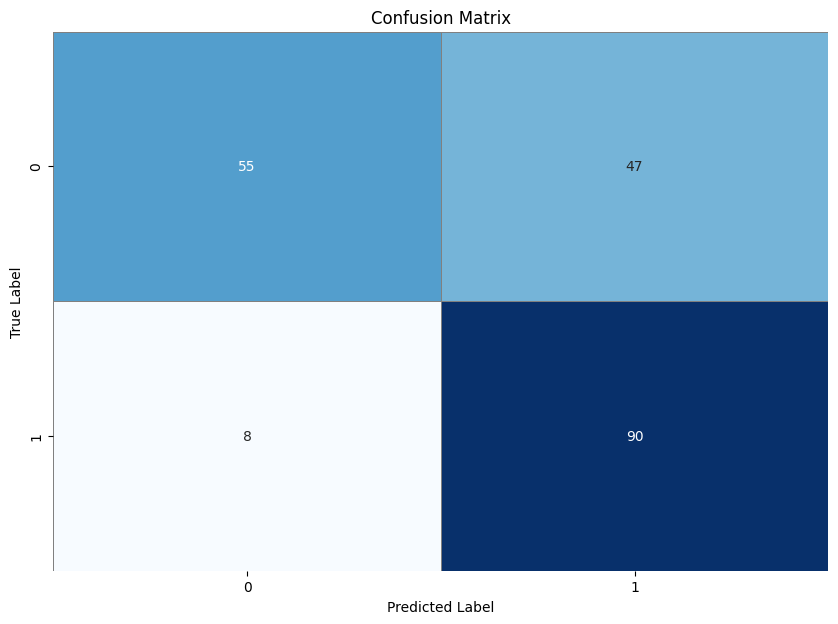

In [19]:
plot_confusion_matrix(y_test, y_pred_test, class_labels=None, normalize=True, cmap='Blues')


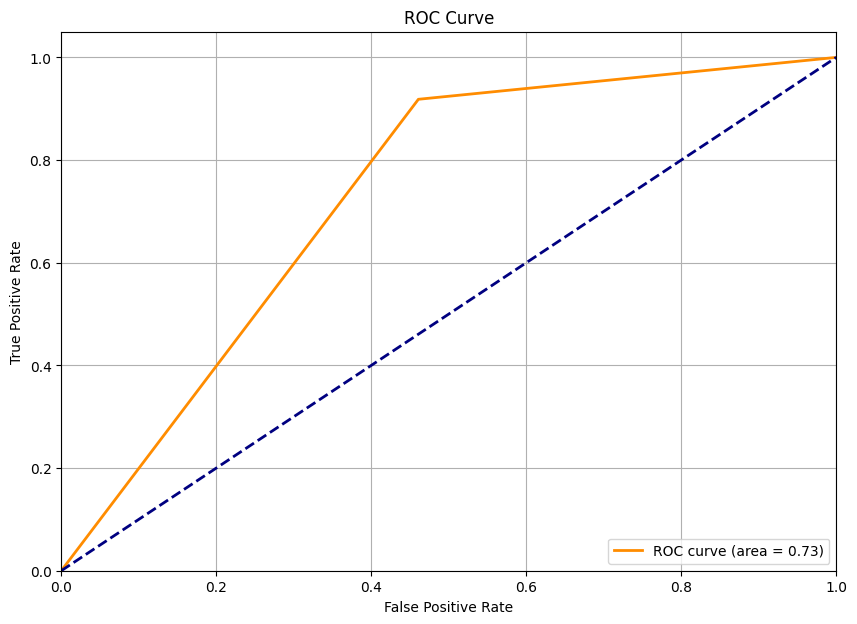

In [20]:
plot_roc_curve(y_test, y_pred_test, pos_label=1)

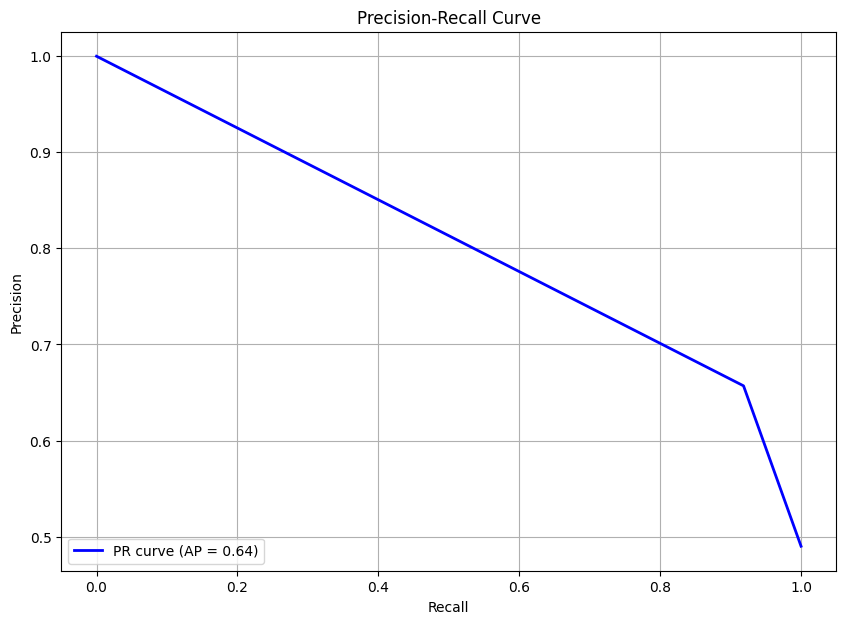

In [21]:
plot_precision_recall_curve(y_test, y_pred_test, pos_label=1)